In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from models import Models
import matplotlib.pyplot as plt
from morph import Morph

In [2]:
from aeon.datasets import load_classification

X, y = load_classification("ECG200")

y = np.where(y == '-1', 0, y)
y = y.astype(np.float64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [3]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(160, 1, 96) (40, 1, 96) (160,) (40,)


In [4]:
lstm = Models('lstm', X_train, y_train)
lstm.train_lstm()

catch22 = Models('catch22', X_train, y_train)
catch22.train_catch22()

rocket = Models('rocket', X_train, y_train)
rocket.train_rocket()

In [5]:
test = Morph(X_test, y_test)
test.get_DTWGlobalBorderline(50)

In [6]:
test.Binay_MorphingCalculater(rocket, verbose=True)

Pair-Wise Results:
Pair: (4, 5) -> Morphing percentage: 0.67
Pair: (2, 17) -> Morphing percentage: 0.47
Pair: (2, 31) -> Morphing percentage: 0.57
Pair: (6, 14) -> Morphing percentage: 0.71
Pair: (2, 18) -> Morphing percentage: 0.50
Pair: (2, 8) -> Morphing percentage: 0.64
Pair: (2, 14) -> Morphing percentage: 0.61
Pair: (2, 13) -> Morphing percentage: 0.44
Pair: (4, 14) -> Morphing percentage: 0.65
Pair: (4, 17) -> Morphing percentage: 0.55
Pair: (0, 17) -> Morphing percentage: 0.77
Pair: (2, 1) -> Morphing percentage: 0.56
Pair: (6, 17) -> Morphing percentage: 0.59
Pair: (2, 20) -> Morphing percentage: 0.66
Pair: (7, 7) -> Morphing percentage: 0.54
Pair: (5, 19) -> Morphing percentage: 0.51
Pair: (0, 14) -> Morphing percentage: 0.68
Pair: (1, 5) -> Morphing percentage: 0.77
Pair: (6, 5) -> Morphing percentage: 0.72
Pair: (2, 27) -> Morphing percentage: 0.48
Pair: (6, 31) -> Morphing percentage: 0.66
Pair: (2, 6) -> Morphing percentage: 0.61
Pair: (0, 20) -> Morphing percentage: 0.81

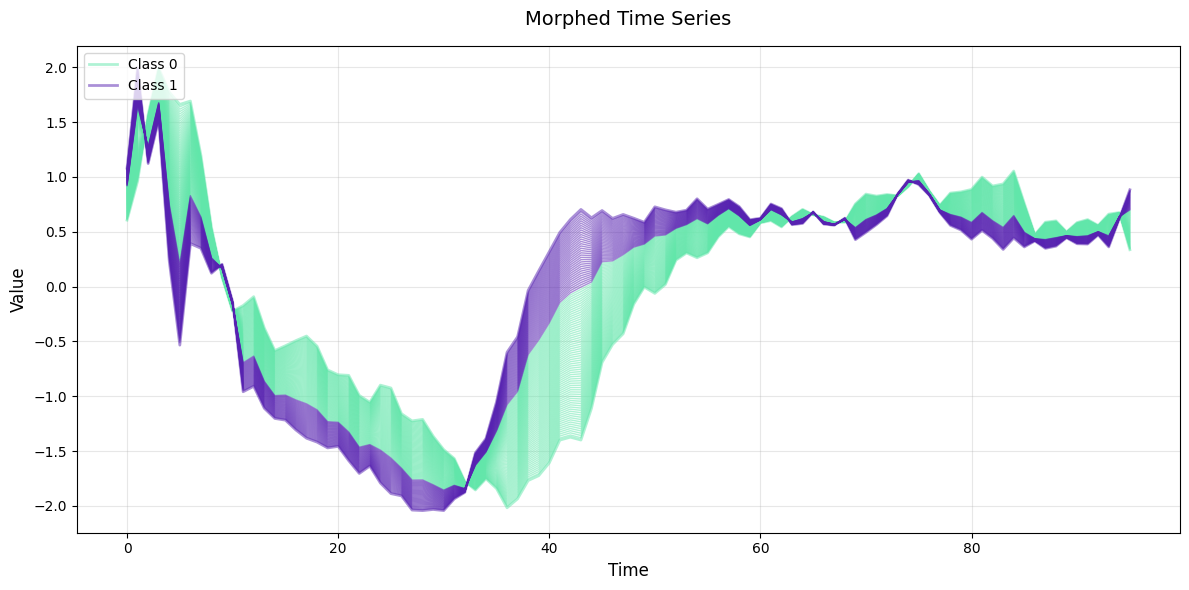

In [7]:
test.plot_morph((4,5))